In [1]:
#Importing the libraries
import torch
import torch.nn as nn
import os
import sys
import pickle
import random
import numpy as np
import gzip
import gensim.downloader as gen_api
from gensim.models import KeyedVectors 
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tqdm import tqdm

In [2]:
#Dataset definition from DLStudio
class SentimentAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_file, path_to_saved_embeddings):
        super(SentimentAnalysisDataset, self).__init__()
               
        f = gzip.open(dataset_file, 'rb') #Opening the compressed dataset file 
        dataset = f.read() #dataset contains the binary objects of the file
        self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv') #Loading the embeddings for the words as a hashmap
        
        #Converting the binary string to Python objects
        self.positive_reviews, self.negative_reviews, self.vocab = pickle.loads(dataset, encoding='latin1')
        #1. Vocab is a list of all the unique words in the dataset
        #2. positive_reviews and negative_reviews is a hashmap consisting of 25 keys corresponding to 25 
        # different categories. The value corresponding to the category key consists of reviews which are 2D strings with 
        # each row corresponding to a specific review and the column of that row corresponding to a word
        
        #Storing each review along with its category and sentiment in a list
        self.indexed_dataset = []
        for category in self.positive_reviews:             #Iterating through all the categories
            for review in self.positive_reviews[category]: #Iterating through all the reviews in each category
                self.indexed_dataset.append([review, category, 1]) #1 indicates positive sentiment
        for category in self.negative_reviews:             #Iterating through all the categories
            for review in self.negative_reviews[category]: #Iterating through all the reviews in each category
                self.indexed_dataset.append([review, category, 0]) #0 indicates negative sentiment

    def review_to_tensor(self, review):
        #Converts each word of the review into its embedding of shape 300        
        list_of_embeddings = []
        for word in review: #Iterating through each word in the review
            if word in self.word_vectors.key_to_index: #Checking if the embedding for the word exists
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding)) #Appending its embedding to the embedding of all the other words
            else:
                next
        #Converting the list to a tensor
        review_array = np.array(list_of_embeddings)
        review_tensor = torch.from_numpy(review_array) 
        return review_tensor #Its of shape (num_words x 300)

    def __len__(self):
        #Returns the length of the dataset
        return len(self.indexed_dataset)

    def __getitem__(self, idx):
        #Extracts an individual review along with its category and sentiment
        sample = self.indexed_dataset[idx]
        review = sample[0]
        review_category = sample[1]
        review_sentiment = sample[2]      
        
        #Converts the review words to its embeddings for each word of the review
        review_tensor = self.review_to_tensor(review)        
        
        #Wrapping up the review, category and sentiment in a hashmap
        sample = {'review'       : review_tensor, 
                  'sentiment'    : review_sentiment }
        return sample



In [3]:
#Model architecture from DLStudio
class GRUnet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers,bidirectional = True) #Using PyTorch's implementation of GRU
        self.fc = nn.Linear(2*hidden_size, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        out, h_new = self.gru(x, h)
        final_o = torch.cat((h_new[2,:,:],h_new[3,:,:]),1) #Concatenating the output of left to right(2) and right to left(3)
        fout = self.fc(self.relu(final_o))
        fout = self.logsoftmax(fout)
        return fout, h_new

    def init_hidden(self):
        #Creates the first hidden input which is all zeros
        weight = next(self.parameters()).data
        hidden = weight.new( 2*self.num_layers, 1,self.hidden_size).zero_()
        return hidden

In [4]:
def testing(net,device,test_dataloader):
  test_corr = 0
  net.eval()
  with torch.no_grad():
    loop = tqdm(test_dataloader)
    for i,data in enumerate(loop):
       review_tensor,sentiment = data['review'], data['sentiment']
       review_tensor = review_tensor.to(device)
       sentiment = sentiment.to(device)
       #Initializing the hidden to 0
       hidden = net.init_hidden().to(device)
      
       #Passing the entire review through the model
       output, hidden = net(torch.unsqueeze(review_tensor[0],1), hidden)
       predicted = torch.max(output.data, 1)[1] 
       test_corr += (predicted == sentiment).item()

  return (test_corr*100)/len(test_dataloader.dataset)         

In [5]:
#From DLStudio
def training(net, criterion, optimizer, epochs, train_dataloader, test_dataloader, device): 
    training_loss = [] #Keeping track of the loss across epochs
    test_accs = [] #Keeping track of test accuracies across epochs
   
    #Iterating through the epochs
    for epoch in range(epochs):  
        running_loss = 0.0
        loop = tqdm(train_dataloader)
        #Iterating through the dataloader
        for i, data in enumerate(loop):
            #Extracting the review and sentiment
            review_tensor,sentiment = data['review'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)
            optimizer.zero_grad()
            
            #Initializing the hidden to 0
            hidden = net.init_hidden().to(device)            
  
            #Passing the entire review through the model
            output, hidden = net(torch.unsqueeze(review_tensor[0],1), hidden) 
            #input is of shape (num_words,1,300)
            #hidden is of shape (1,1,100)

            #Computing loss
            loss = criterion(output,sentiment)
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item()) 
            loss.backward()
            optimizer.step()
            
        training_loss.append((running_loss)/(i+1))
        test_acc = testing(net,device,test_dataloader)
        test_accs.append(test_acc)
        net.train()
        print("[epoch: %d, batch: %5d] Loss: %.3f Test Accuracy: %.3f " % (epoch + 1, i + 1, (running_loss)/(i+1),test_acc))
        
        
    return net, training_loss, test_accs

In [6]:
#Function to compute the confusion matrix
def confusion_matrix(model,test_data_loader,device):
  matrix = torch.zeros((2,2))
  model.eval()
  with torch.no_grad():
    for i,data in enumerate(test_dataloader):
       review_tensor,sentiment = data['review'], data['sentiment']
       review_tensor = review_tensor.to(device)
       sentiment = sentiment.to(device)
       #Initializing the hidden to 0
       hidden = model.init_hidden().to(device)
      
       #Passing the entire review through the model
       output, hidden = model(torch.unsqueeze(review_tensor[0],1), hidden) 

       predicted = torch.max(output.data, 1)[1] 
       matrix[predicted.cpu(),sentiment.cpu()] += 1

  heat = pd.DataFrame(matrix, index = [i for i in ["Negative","Positive"]],
                  columns = [i for i in ["Negative","Positive"]])
  heat = heat.astype(int)
  accuracy = (matrix.trace()/matrix.sum())*100
  plt.figure(figsize = (10,7))
  plt.title("Total accuracy is "+str(accuracy.item()))
  s = sn.heatmap(heat, annot=True,cmap='Blues',fmt='g')
  s.set(xlabel='Ground Truth', ylabel='Predicted')
  

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = GRUnet(input_size=300,hidden_size=100,output_size=2,num_layers=2).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,betas=(0.9,0.99))
epochs = 6


In [9]:
train_dataset = SentimentAnalysisDataset(dataset_file ="/content/drive/MyDrive/DL_HW8/sentiment_dataset_train_400.tar.gz",path_to_saved_embeddings="/content/drive/MyDrive/DL_HW8/") 
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=True, num_workers=2)

test_dataset = SentimentAnalysisDataset(dataset_file ="/content/drive/MyDrive/DL_HW8/sentiment_dataset_test_400.tar.gz",path_to_saved_embeddings="/content/drive/MyDrive/DL_HW8/") 
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True, num_workers=2)

print("The size of the training dataset is "+ str(len(train_dataset)))
print("The size of the test dataset is "+ str(len(test_dataset)))

The size of the training dataset is 14227
The size of the test dataset is 3563


In [10]:
trained_model, training_loss, test_accs = training(model, criterion, optimizer, epochs, train_dataloader,test_dataloader, device)

100%|██████████| 3563/3563 [00:13<00:00, 263.17it/s]


[epoch: 1, batch: 14227] Loss: 0.464 Test Accuracy: 83.188 


100%|██████████| 3563/3563 [00:13<00:00, 262.71it/s]


[epoch: 2, batch: 14227] Loss: 0.327 Test Accuracy: 87.118 


100%|██████████| 3563/3563 [00:13<00:00, 260.61it/s]


[epoch: 3, batch: 14227] Loss: 0.273 Test Accuracy: 84.199 


100%|██████████| 3563/3563 [00:13<00:00, 254.54it/s]


[epoch: 4, batch: 14227] Loss: 0.218 Test Accuracy: 86.304 


100%|██████████| 3563/3563 [00:13<00:00, 257.00it/s]


[epoch: 5, batch: 14227] Loss: 0.163 Test Accuracy: 87.567 


100%|██████████| 3563/3563 [00:13<00:00, 261.36it/s]

[epoch: 6, batch: 14227] Loss: 0.129 Test Accuracy: 86.584 


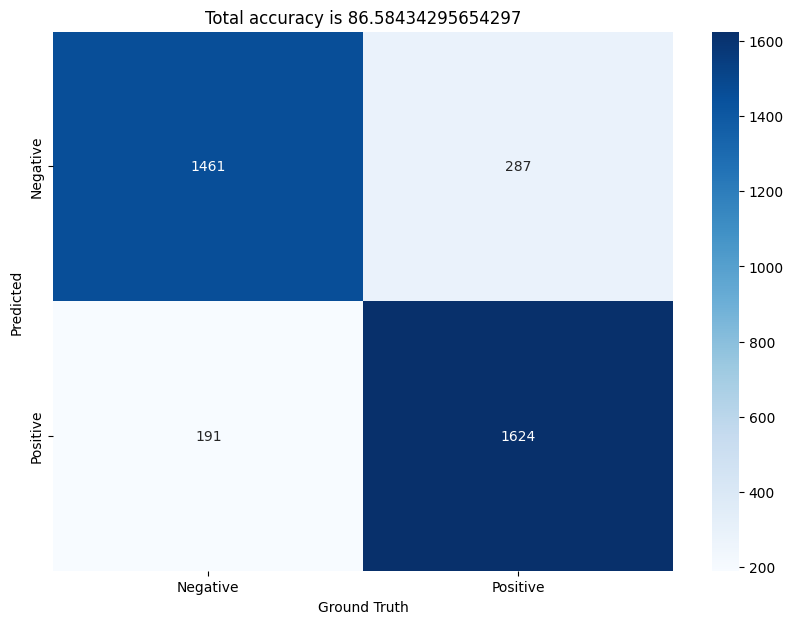

In [11]:
confusion_matrix(trained_model,test_dataloader,device)

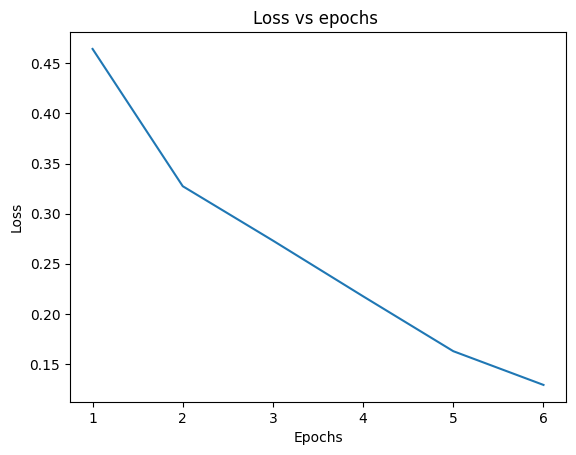

In [12]:
#Plotting the training loss vs epochs 
epochs = np.arange(1,7)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs epochs ")
plt.plot(epochs,training_loss)


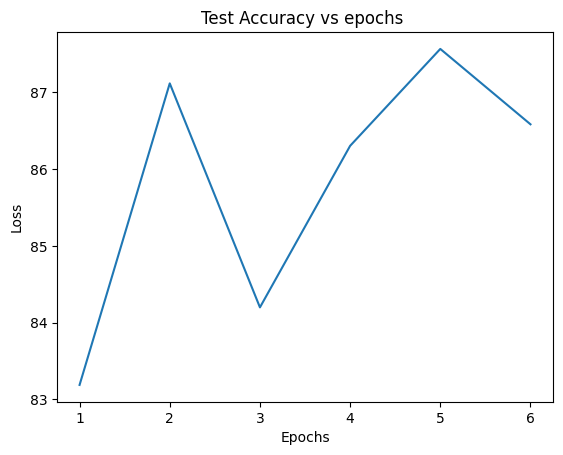

In [13]:
#Plotting the test accuracy vs epochs 
epochs = np.arange(1,7)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Accuracy vs epochs ")
plt.plot(epochs,test_accs)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
#Number of parameters in the model
count_parameters(trained_model)

422802